In [1]:
import os
import sys
import shutil

# Detect if running on Kaggle or Local
IS_KAGGLE = os.path.exists('/kaggle')

if IS_KAGGLE:
    DATA_2017_INPUT = '/kaggle/input/cicids2017clean'
    DATA_2018_INPUT = '/kaggle/input/cicids2018clean'
else:
    # Local paths
    DATA_2017_INPUT = '/Users/nguyentiendang0106/Documents/d4l_ds_2025/data/2017/clean'
    DATA_2018_INPUT = '/Users/nguyentiendang0106/Documents/d4l_ds_2025/data/2018/clean'

print("Running on:", "Kaggle" if IS_KAGGLE else "Local")
print("2017 data:", DATA_2017_INPUT)
print("2018 data:", DATA_2018_INPUT)


Running on: Local
2017 data: /Users/nguyentiendang0106/Documents/d4l_ds_2025/data/2017/clean
2018 data: /Users/nguyentiendang0106/Documents/d4l_ds_2025/data/2018/clean


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# from IPython.display import display

def load_data(clean_dir, sample_size=1948, train_size=100000, val_size=100000, test_size=30000, train_size_malicious=0.7, file_type="parquet", verbose=True):
    # Read data
    if file_type == "parquet":
        df_benign = pd.read_parquet(f"{clean_dir}/all_benign.parquet")
        df_malicious = pd.read_parquet(f"{clean_dir}/all_malicious.parquet")
    elif file_type == "feather":
        df_benign = pd.read_feather(f"{clean_dir}/all_benign.feather")
        df_malicious = pd.read_feather(f"{clean_dir}/all_malicious.feather")
        
    attack_type = df_malicious.Label.copy()

    # Map label to attack type
    df_malicious.Label = df_malicious.Label.map({
        'DoS Hulk':'(D)DOS', 
        'PortScan':'Port Scan', 
        'DDoS':'(D)DOS', 
        'DoS slowloris':'(D)DOS', 
        'DoS Slowhttptest':'(D)DOS', 
        'DoS GoldenEye':'(D)DOS', 
        'SSH-Patator':'Brute Force', 
        'FTP-Patator':'Brute Force', 
        'Bot': 'Botnet', 
        'Web Attack \x96 Brute Force': 'Web Attack', 
        'Web Attack \x96 Sql Injection': 'Web Attack', 
        'Web Attack \x96 XSS': 'Web Attack',
        'Infiltration': 'Infiltration',
        'Heartbleed': 'Heartbleed',

        # 2018
        'DDoS attacks-LOIC-HTTP': '(D)DOS',
        'DDOS attack-HOIC': '(D)DOS',
        'DoS attacks-Hulk': '(D)DOS',
        'DoS attacks-GoldenEye': '(D)DOS',
        'DoS attacks-Slowloris': '(D)DOS',
        'DDOS attack-LOIC-UDP': '(D)DOS',
        'DoS attacks-SlowHTTPTest': '(D)DOS', # Assuming this exists in data2
        'Bot': 'Botnet',
        'SSH-Bruteforce': 'Brute Force',
        'FTP-BruteForce': 'FTP-BruteForce', # Assuming this exists in data2
        'Brute Force -Web': 'Brute Force', # Grouping Web Brute force with others
        'Brute Force -XSS': 'Web Attack', # Keeping XSS as Web Attack
        'SQL Injection': 'Web Attack', # Assuming this exists in data2
        'Infilteration': 'Unknown' # Mapping Infiltration to Unknown
    })


    # Split benign data in train, validation, test split
    y_benign = np.ones(df_benign.shape[0])
    x_benign = df_benign.drop(columns=['Label', 'Timestamp', 'Destination Port'])

    x_benign_train, x_benign_valtest, y_benign_train, y_benign_valtest = train_test_split(x_benign, y_benign, train_size=train_size, random_state=42, shuffle=True)
    x_benign_val, x_benign_test, y_benign_val, y_benign_test = train_test_split(x_benign_valtest, y_benign_valtest, train_size=val_size, test_size=test_size, random_state=42, shuffle=True)

    # Split malicious data in train, test split
    train_idx, test_idx = sub_sample_train_test(df_malicious, attack_type, sample_size, train_size_malicious)
    y_multi = df_malicious.Label
    x_multi = df_malicious.drop(columns=['Label', 'Timestamp', 'Destination Port'])
    x_malicious_train, x_malicious_test, y_malicious_train, y_malicious_test = (x_multi.iloc[train_idx], x_multi.iloc[test_idx], y_multi.iloc[train_idx], y_multi.iloc[test_idx])
    attack_type_train, attack_type_test = (attack_type.iloc[train_idx], attack_type.iloc[test_idx])
    
    if verbose:
        overview = {}
        overview[('Benign', 'Benign')] = {
            "#Original": df_benign.shape[0], 
            "#Sampled": x_benign_train.shape[0] + x_benign_val.shape[0] + x_benign_test.shape[0], 
            "#Train": x_benign_train.shape[0], 
            "#Validation": x_benign_val.shape[0], 
            '%Validation': 100,
            "#Test": x_benign_test.shape[0],
            '%Test': 100,
        }
        for attack_class in np.unique(y_multi):
            attack_impl_train_count = attack_type_train[y_malicious_train == attack_class].value_counts()
            attack_impl_test_count = attack_type_test[y_malicious_test == attack_class].value_counts()
            for attack_impl in np.unique(np.concatenate([attack_impl_test_count.keys(), attack_impl_train_count.keys()])):
                train_count = attack_impl_train_count[attack_impl] if attack_impl in attack_impl_train_count else 0
                test_count = attack_impl_test_count[attack_impl] if attack_impl in attack_impl_test_count else 0
                overview[(attack_class, attack_impl)] = {
                    "#Original": (attack_type == attack_impl).sum(), 
                    "#Sampled": train_count + test_count, 
                    "#Train": 0, 
                    "#Validation": train_count if sum(attack_impl_train_count) > 0 else '-', 
                    '%Validation': train_count / sum(attack_impl_train_count) * 100 if sum(attack_impl_train_count) > 0 else '-', 
                    "#Test": test_count,
                    '%Test': test_count / sum(attack_impl_test_count) * 100,
                }
            overview[(attack_class, 'ALL')] = {
                "#Original": (attack_class == y_multi).sum(), 
                "#Sampled": sum(attack_impl_train_count) + sum(attack_impl_test_count), 
                "#Train": 0, 
                "#Validation": sum(attack_impl_train_count) if sum(attack_impl_train_count) > 0 else '-', 
                '%Validation': 100 if sum(attack_impl_train_count) > 0 else '-', 
                "#Test": sum(attack_impl_test_count),
                '%Test': 100,
            }
        print(pd.DataFrame.from_dict(overview, orient="index").rename_axis(["Class", "Impl"]))
    
    # Prepare final datasets
#     x_binary_val = np.concatenate((x_benign_val, x_malicious_train))
#     y_binary_val = np.concatenate((y_benign_val, np.full(y_malicious_train.shape[0], -1)))

#     x_binary_test = np.concatenate((x_benign_test, x_malicious_test))
#     y_binary_test = np.concatenate((y_benign_test, np.full(y_malicious_test.shape[0], -1)))
    
    return (x_benign_train, y_benign_train, x_benign_val, y_benign_val, x_benign_test, y_benign_test, x_malicious_train, y_malicious_train, x_malicious_test, y_malicious_test, attack_type_train, attack_type_test, attack_type)

def sub_sample_train_test(df, attack_type_label, sample_size, train_size=0.7, random_seed=42):
    # Returns indexes of train and test split
    # Classes with not enough samples will all be in the test split
    random_state = np.random.RandomState(random_seed)
    train_idx = np.empty((0,), dtype=int)
    test_idx = np.empty((0,), dtype=int)

    for attack_type in np.unique(df.Label):
        attack_type_count = np.count_nonzero(df.Label == attack_type)
        if attack_type_count < sample_size:
            # Use attack class for testing only, not enough samples for training
            test_idx = np.concatenate((test_idx, np.flatnonzero(df.Label == attack_type)))
        else:
            # Splits attack class over train and test set in stratified manner
            attack_train_idx, attack_test_idx = train_test_split(range(attack_type_count), test_size=round(sample_size*(1-train_size)), train_size=round(sample_size*train_size), random_state=random_seed, stratify=attack_type_label[df.Label == attack_type])
            attack_original_idx = np.flatnonzero(df.Label == attack_type)
            train_idx = np.concatenate((train_idx, attack_original_idx[attack_train_idx]))
            test_idx = np.concatenate((test_idx, attack_original_idx[attack_test_idx]))

    random_state.shuffle(train_idx)
    random_state.shuffle(test_idx)
    return (train_idx, test_idx)

def anomaly_scores(original, transformed):
    sse = np.sum((original - transformed)**2, axis=1)
    return sse

def evaluate_results(y_true, score):
    precision, recall, threshold = precision_recall_curve(y_true, score, pos_label=-1)
    au_precision_recall = auc(recall, precision)
    results = pd.DataFrame({'precision': precision, 'recall': recall})
    results["f1"] = 2*precision*recall/(precision+recall)
    results["f2"] = 5*precision*recall/(4*precision+recall)
    max_index_f1 = results["f1"].idxmax()
    max_index_f2 = results["f2"].idxmax()
    best = pd.concat([results.loc[max_index_f1], results.loc[max_index_f2]], keys= ["f1", "f2"])
    best["f1threshold"] = threshold[max_index_f1]
    best["f2threshold"] = threshold[max_index_f2]
    best["au_precision_recall"] = au_precision_recall
    fpr, tpr, thresholds = roc_curve(y_true, score, pos_label=-1)
    best["auroc"] = auc(fpr, tpr)
    return best

def evaluate_proba(y_true, score):
    precision, recall, threshold = precision_recall_curve(y_true, score, pos_label=-1)
    results = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': np.append(threshold, np.inf)})
    best_index_fscore = {}
    f_scores = []
    for i in range(1, 10):
        results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
        best_index = results[f"F{i}"].idxmax()
        f_scores.append({
            "metric": f"F{i}", 
            "value": str(round(results[f'F{i}'][best_index], 4)), 
            "threshold": threshold[best_index],
            "precision": str(round(results["precision"][best_index], 4)),
            "recall": str(round(results["recall"][best_index], 4)),
            "FPR": (score[(y_true == 1)] >= threshold[best_index]).sum() / (y_true == 1).sum()
        })
    return results, pd.DataFrame(f_scores)

def plot_fscores(scores, summary, figsize=(10,6), min_recall=0.25, show_thresholds=False):
    n_points = sum(scores['recall'] >= min_recall)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(scores.loc[:n_points, 'threshold'], scores.loc[:n_points, 'recall'], label="recall", color="black")
    ax.plot(scores.loc[:n_points, 'threshold'], scores.loc[:n_points, 'precision'], label="precision", color="silver")
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
    n_curves = 0
    thresholds = []
    for f_col in scores.filter(regex="^F.+"):
        ax.plot(scores.loc[:n_points, 'threshold'], scores.loc[:n_points, f_col], label=f_col, color=colors[n_curves%len(colors)])
        ax.plot(float(summary.loc[summary.metric == f_col, "threshold"]), float(summary.loc[summary.metric == f_col, "value"]), marker="o", color=colors[n_curves%len(colors)])
        thresholds.append(float(summary.loc[summary.metric == f_col, "threshold"]))
        n_curves += 1
    if show_thresholds:
        for t in thresholds:
            ax.axvline(t, 0, 1, color="black", linestyle="--")
    ax.set_xlabel("threshold")
    ax.set_ylabel("value")
    plt.legend()
    return fig

def plot_confusion_matrix(y_true, y_pred, figsize=(7,7), cmap="Blues", values=[-1, 1], labels=["fraud", "benign"], title="", ax=None):
    cm = confusion_matrix(y_true, y_pred, labels=values)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float)
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            annot[i, j] = '%.1f%%\n%d' % (p * 100, c)
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, cmap=cmap, annot=annot, fmt='', ax=ax, vmin=0, vmax=1)
    if title != "":
        ax.set_title(title)

def optimal_fscore_multi(y_true, score, classes, steps=100, start_step=0.0, stop_step=1.0):
    thresholds = np.arange(0.0, 1.0, 1/steps)
    fmacro = np.zeros(shape=(len(thresholds)))
    fweight = np.zeros(shape=(len(thresholds)))
    metrics = {
        "f1_macro": 0,
        "f1_macro_threshold": None,
        "f1_weighted": 0,
        "f1_weighted_threshold": None,
    }
    for index, threshold in enumerate(thresholds):
        # Corrected probabilities
        y_pred = np.where(np.max(score, axis=1) > threshold, classes[np.argmax(score, axis=1)], 'Unknown')
        # Calculate the f-score
        fmacro[index] = f1_score(y_true, y_pred, average='macro')
        if fmacro[index] > metrics["f1_macro"]:
            metrics["f1_macro"] = fmacro[index]
            metrics["f1_macro_threshold"] = threshold
            
        fweight[index] = f1_score(y_true, y_pred, average='weighted')
        if fweight[index] > metrics["f1_weighted"]:
            metrics["f1_weighted"] = fweight[index]
            metrics["f1_weighted_threshold"] = threshold
    return fmacro, fweight, thresholds, metrics

def plot_f_multi(fmacro, fweight, thresholds, metrics, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(thresholds, fmacro, label=f"F1 Macro ({round(metrics['f1_macro'], 3)})", color="tab:blue")
    ax.plot(thresholds, fweight, label=f"F1 Weight ({round(metrics['f1_weighted'],3)})", color="tab:orange")
    ax.plot(metrics["f1_macro_threshold"], metrics["f1_macro"], marker="o")
    ax.plot(metrics["f1_weighted_threshold"], metrics["f1_weighted"], marker="o")
    ax.set_xlabel("threshold")
    ax.set_ylabel("value")
    plt.legend()
    return fig


In [4]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

import pandas as pd
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.metrics import auc, roc_curve, accuracy_score, balanced_accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import pathlib
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2



train = {
    "ocsvm": {}, # 10k samples
    "ae": {}, # 100k samples
    "stage2": {}
}
val = {
    "ocsvm": {},
    "ae": {},
    "stage2": {}
}
test = {
    # "y"
    # "y_binary"
    # "y_unknown"
    # "x"
}

# LOAD DATA STAGE 1

In [4]:
clean_dir = DATA_2017_INPUT


train["ocsvm"]["x"], train["ocsvm"]["y"], x_benign_val, y_benign_val, _, _, x_malicious_train, y_malicious_train, _, _, _, _, _ = load_data(clean_dir, sample_size=1948, train_size=10000, val_size=129485, test_size=56468)

val["ocsvm"]["x"] = np.concatenate((x_benign_val, x_malicious_train))
val["ocsvm"]["y"] = np.concatenate((y_benign_val, np.full(y_malicious_train.shape[0], -1)))


train["ae"]["x"], train["ae"]["y"], x_benign_val, y_benign_val, _, _, x_malicious_train, y_malicious_train, _, _, _, _, _ = load_data(clean_dir, sample_size=1948, val_size=129485, test_size=56468)

val["ae"]["x"] = np.concatenate((x_benign_val, x_malicious_train))
val["ae"]["y"] = np.concatenate((y_benign_val, np.full(y_malicious_train.shape[0], -1)))

                                         #Original  #Sampled  #Train  \
Class        Impl                                                      
Benign       Benign                        2094575    195953   10000   
(D)DOS       DDoS                           128014       775       0   
             DoS GoldenEye                   10286        62       0   
             DoS Hulk                       172788      1047       0   
             DoS Slowhttptest                 5228        31       0   
             DoS slowloris                    5385        33       0   
             ALL                            321701      1948       0   
Botnet       Bot                              1948      1948       0   
             ALL                              1948      1948       0   
Brute Force  FTP-Patator                      5931      1263       0   
             SSH-Patator                      3219       685       0   
             ALL                              9150      1948    

# LOAD DATA STAGE 2

In [5]:
n_benign_val = 1500

x_benign_train, _, _, _, x_benign_test, y_benign_test, x_malicious_train, y_malicious_train, x_malicious_test, y_malicious_test, attack_type_train, _, _ = load_data(clean_dir, sample_size=1948, train_size=n_benign_val, val_size=6815, test_size=56468)
train["stage2"]["x"], x_val, train["stage2"]["y"], y_val = train_test_split(x_malicious_train, y_malicious_train, stratify=attack_type_train, test_size=1500, random_state=42, shuffle=True)

test['x'] = np.concatenate((x_benign_test, x_malicious_test))
test["y_n"] = np.concatenate((y_benign_test, np.full(y_malicious_test.shape[0], -1)))

val["stage2"]["x"] = np.concatenate((x_val, x_benign_train))
val["stage2"]["y"] = np.concatenate((y_val, np.full(n_benign_val, "Unknown")))

train["stage2"]["y_n"] = pd.get_dummies(train["stage2"]["y"])
val["stage2"]["y_n"] = pd.get_dummies(val["stage2"]["y"])

test["y"] = np.concatenate((np.full(56468, "Benign"), y_malicious_test))
test["y_unknown"] = np.where((test["y"] == "Heartbleed") | (test["y"] == "Infiltration"), "Unknown", test["y"])
test["y_unknown_all"] = np.where(test['y_unknown'] == 'Benign', "Unknown", test['y_unknown'])

                                         #Original  #Sampled  #Train  \
Class        Impl                                                      
Benign       Benign                        2094575     64783    1500   
(D)DOS       DDoS                           128014       775       0   
             DoS GoldenEye                   10286        62       0   
             DoS Hulk                       172788      1047       0   
             DoS Slowhttptest                 5228        31       0   
             DoS slowloris                    5385        33       0   
             ALL                            321701      1948       0   
Botnet       Bot                              1948      1948       0   
             ALL                              1948      1948       0   
Brute Force  FTP-Patator                      5931      1263       0   
             SSH-Patator                      3219       685       0   
             ALL                              9150      1948    

# SCALE THE DATA

In [ ]:
import pickle
from pathlib import Path
from sklearn.preprocessing import QuantileTransformer

# Output directory - use local model/ directory if not on Kaggle
if IS_KAGGLE:
    output_dir = Path("/kaggle/working")
else:
    output_dir = Path("/models")

output_dir.mkdir(exist_ok=True)

###############################################
# 1. OCSVM Scaler (normal)
###############################################
scaler_ocsvm = QuantileTransformer(output_distribution='normal')

train['ocsvm']['x_s'] = scaler_ocsvm.fit_transform(train['ocsvm']['x'])
val['ocsvm']['x_s'] = scaler_ocsvm.transform(val['ocsvm']['x'])
test['ocsvm_s'] = scaler_ocsvm.transform(test['x'])

# with open(output_dir / "scaler_ocsvm_normal.p", "wb") as f:
#     pickle.dump(scaler_ocsvm, f)

# print("Saved scaler_ocsvm_normal.p")


###############################################
# 2. AE Scaler (normal)
###############################################
scaler_ae = QuantileTransformer(output_distribution='normal')

train['ae']['x_s'] = scaler_ae.fit_transform(train['ae']['x'])
val['ae']['x_s'] = scaler_ae.transform(val['ae']['x'])
test['ae_s'] = scaler_ae.transform(test['x'])

with open(output_dir / "scaler_ae_normal_stage1.p", "wb") as f:
    pickle.dump(scaler_ae, f)

print("Saved scaler_ae_normal_stage1.p")


###############################################
# 3. Stage2 Scaler (normal)
###############################################
scaler_stage2_normal = QuantileTransformer(output_distribution='normal')

train['stage2']['x_s'] = scaler_stage2_normal.fit_transform(train['stage2']['x'])
val['stage2']['x_s'] = scaler_stage2_normal.transform(val['stage2']['x'])
test['stage2_s'] = scaler_stage2_normal.transform(test['x'])

with open(output_dir / "scaler_stage2_normal_stage2.p", "wb") as f:
    pickle.dump(scaler_stage2_normal, f)

print("Saved scaler_stage2_normal_stage2.p")


###############################################
# 4. Stage2 Scaler (uniform)
###############################################
scaler_stage2_uniform = QuantileTransformer(output_distribution='uniform')

train['stage2']['x_q'] = scaler_stage2_uniform.fit_transform(train['stage2']['x'])
val['stage2']['x_q'] = scaler_stage2_uniform.transform(val['stage2']['x'])
test['stage2_q'] = scaler_stage2_uniform.transform(test['x'])

# with open(output_dir / "scaler_stage2_uniform.p", "wb") as f:
#     pickle.dump(scaler_stage2_uniform, f)

# print("Saved scaler_stage2_uniform.p")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Saved scaler_ocsvm_normal.p


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Saved scaler_ae_normal_stage1.p


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Saved scaler_stage2_normal_stage2.p


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Saved scaler_stage2_uniform.p


# TRAIN MODELS

## STAGE 1: One-Class SVM

In [8]:
def create_ocsvm(params):
    return Pipeline(
        [
            ("pca", PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=42)), 
            ("ocsvm", OneClassSVM(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=True, max_iter=-1))
        ]
    ).set_params(**params)

### Train

In [ ]:
params_ocsvm_10k = {
    "pca__n_components": 56,
    "ocsvm__kernel": "rbf",
    "ocsvm__gamma": 0.0632653906314333,
    "ocsvm__nu": 0.0002316646233151
}
ocsvm_model_10k = create_ocsvm(params_ocsvm_10k)
ocsvm_model_10k.fit(train['ocsvm']['x_s'])
# with open(output_dir / "ocsvm_model_10k.p", "wb") as f:
#     pickle.dump(ocsvm_model_10k, f)

# print("Saved ocsvm_model_10k.p")

[LibSVM]*
optimization finished, #iter = 860
obj = 0.005531, rho = 0.004726
nSV = 844, nBSV = 0
Saved ocsvm_model_10k.p


## Train with equal training size as AE (100k)

In [10]:
params_ocsvm_100k = {
    "pca__n_components": 56,
    "ocsvm__kernel": "rbf",
    "ocsvm__gamma": 0.0632653906314333,
    "ocsvm__nu": 0.0002316646233151
}
ocsvm_model_100k = create_ocsvm(params_ocsvm_100k)
ocsvm_model_100k.fit(train['ae']['x_s'])
with open(output_dir / "ocsvm_model_100k_stage1.p", "wb") as f:
    pickle.dump(ocsvm_model_100k, f)

print("Saved ocsvm_model_100k_stage1.p")

[LibSVM].*..
*
optimization finished, #iter = 3763
obj = 0.216488, rho = 0.018672
nSV = 2919, nBSV = 0
Saved ocsvm_model_100k_stage1.p


### Validation

In [11]:
score_val_10k = -ocsvm_model_10k.decision_function(val['ocsvm']['x_s'])
curves_metrics_10k, summary_metrics_10k = evaluate_proba(val['ocsvm']['y'], score_val_10k)

In [12]:
summary_metrics_10k

,metric,value,threshold,precision,recall,FPR
0,F1,0.3517,0.000829,0.3223,0.3871,0.042878
1,F2,0.4318,0.000017,0.1671,0.7152,0.187821
2,F3,0.5558,-0.000100,0.1417,0.8229,0.262416
3,F4,0.6703,-0.000353,0.1117,0.9751,0.408410
4,F5,0.7516,-0.000353,0.1117,0.9751,0.408410
5,F6,0.8066,-0.000353,0.1117,0.9751,0.408410
6,F7,0.8445,-0.000353,0.1117,0.9751,0.408410
7,F8,0.8715,-0.000358,0.1111,0.9758,0.411075
8,F9,0.8914,-0.000366,0.1101,0.977,0.416025


In [13]:
score_val_100k = -ocsvm_model_100k.decision_function(val['ae']['x_s'])
curves_metrics_100k, summary_metrics_100k = evaluate_proba(val['ae']['y'], score_val_100k)

In [14]:
summary_metrics_100k

,metric,value,threshold,precision,recall,FPR
0,F1,0.4613,0.001610,0.5928,0.3776,0.013662
1,F2,0.4377,-0.001525,0.1479,0.8576,0.260146
2,F3,0.5796,-0.001525,0.1479,0.8576,0.260146
3,F4,0.6689,-0.001525,0.1479,0.8576,0.260146
4,F5,0.7269,-0.002037,0.1283,0.8935,0.319620
5,F6,0.773,-0.002933,0.109,0.9304,0.400510
6,F7,0.8119,-0.004553,0.0839,0.9865,0.567054
7,F8,0.8465,-0.004570,0.0837,0.9871,0.569193
8,F9,0.8723,-0.004574,0.0836,0.9872,0.569865


#### Define Thresholds


In [15]:
quantiles = [0.995, 0.99, 0.975, 0.95]
print({(metric, fpr): t for metric, fpr, t in zip(summary_metrics_10k.metric, summary_metrics_10k.FPR, summary_metrics_10k.threshold)})
print({q: np.quantile(score_val_10k[val["ocsvm"]["y"] == 1], q) for q in quantiles})

{('F1', 0.042877553384561916): 0.0008291784564489844, ('F2', 0.18782098312545856): 1.6779450491356644e-05, ('F3', 0.2624164961192416): -9.978544207155625e-05, ('F4', 0.4084102405684056): -0.00035322997676019013, ('F5', 0.4084102405684056): -0.00035322997676019013, ('F6', 0.4084102405684056): -0.00035322997676019013, ('F7', 0.4084102405684056): -0.00035322997676019013, ('F8', 0.4110746418504074): -0.00035810203046511557, ('F9', 0.41602502220334403): -0.00036598641744344136}
{0.995: 0.004689103415209184, 0.99: 0.004159370404940041, 0.975: 0.0020688018569035857, 0.95: 0.000635767722524774}


In [16]:
quantiles = [0.995, 0.99, 0.975, 0.95]
print({(metric, fpr): t for metric, fpr, t in zip(summary_metrics_100k.metric, summary_metrics_100k.FPR, summary_metrics_100k.threshold)})
print({q: np.quantile(score_val_100k[val["ae"]["y"] == 1], q) for q in quantiles})

{('F1', 0.01366181410974244): 0.0016096585548964412, ('F2', 0.2601459628528401): -0.0015251294822505972, ('F3', 0.2601459628528401): -0.0015251294822505972, ('F4', 0.2601459628528401): -0.0015251294822505972, ('F5', 0.31962003320847976): -0.0020373421372388983, ('F6', 0.40050971154960036): -0.0029331903869861536, ('F7', 0.5670540989303781): -0.004552589202496418, ('F8', 0.5691933428582461): -0.004569803192529469, ('F9', 0.5698652353554465): -0.0045741559351979745}
{0.995: 0.008197119324398096, 0.99: 0.0029087824072017237, 0.975: 0.00034081945166690263, 0.95: -6.71058980878963e-05}


### Test

In [17]:
score_test_10k = -ocsvm_model_10k.decision_function(test['ocsvm_s'])
curves_metrics_test_10k, summary_metrics_test_10k = evaluate_proba(test["y_n"], score_test_10k)
summary_metrics_test_10k

/tmp/ipykernel_84/3129305914.py:164: RuntimeWarning: divide by zero encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/tmp/ipykernel_84/3129305914.py:164: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/tmp/ipykernel_84/3129305914.py:164: RuntimeWarning: divide by zero encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/tmp/ipykernel_84/3129305914.py:164: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/tmp/ipykernel_84/3129305914.py:164: RuntimeWarning: divide by zero encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/tmp/ipykernel_84/3129305914.py:164: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/tmp/ipykernel_84/3129305914.py:164: 

,metric,value,threshold,precision,recall,FPR
0,F1,0.362,0.000827,0.3299,0.4011,0.042803
1,F2,0.4428,0.000037,0.1767,0.7105,0.173992
2,F3,0.5587,-0.000098,0.1437,0.8227,0.257633
3,F4,0.673,-0.000353,0.1128,0.9757,0.403060
4,F5,0.754,-0.000353,0.1128,0.9757,0.403060
5,F6,0.8086,-0.000353,0.1128,0.9757,0.403060
6,F7,0.8463,-0.000353,0.1128,0.9757,0.403060
7,F8,0.873,-0.000353,0.1128,0.9757,0.403060
8,F9,0.8926,-0.000495,0.0988,0.9909,0.474888


In [18]:
score_test_100k = -ocsvm_model_100k.decision_function(test['ae_s'])
curves_metrics_test_100k, summary_metrics_test_100k = evaluate_proba(test["y_n"], score_test_100k)
summary_metrics_test_100k

,metric,value,threshold,precision,recall,FPR
0,F1,0.477,0.001534,0.6123,0.3906,0.012999
1,F2,0.4425,-0.001524,0.1505,0.8591,0.254764
2,F3,0.5841,-0.001524,0.1505,0.8591,0.254764
3,F4,0.6728,-0.001524,0.1505,0.8591,0.254764
4,F5,0.7324,-0.002013,0.1315,0.8962,0.310955
5,F6,0.7777,-0.002935,0.1104,0.9346,0.395587
6,F7,0.8143,-0.003080,0.1074,0.9407,0.410781
7,F8,0.8462,-0.004561,0.0839,0.9862,0.565595
8,F9,0.872,-0.004638,0.0828,0.9882,0.574998


## STAGE 2: Random Forest

In [19]:
def create_rf(params):
    return RandomForestClassifier(random_state=42).set_params(**params)

In [20]:
params = {
    "n_estimators": 97,
    "max_samples": 0.9034128710297624,
    "max_features": 0.1751204590963604,
    "min_samples_leaf": 1
}
rf_model_base = create_rf(params)
rf_model_base.fit(train['stage2']['x_s'], train["stage2"]["y"])
with open(output_dir / "baseline_rf.p", "wb") as f:
    pickle.dump(rf_model_base, f)
print("Saved baseline_rf.p")

Saved baseline_rf.p


### Validation

In [21]:
y_proba_val_2 = rf_model_base.predict_proba(val['stage2']['x_s'])

#### Define Thresholds

In [22]:
fmacro, fweight, threshold_fscore, f_best = optimal_fscore_multi(val['stage2']['y'], y_proba_val_2, rf_model_base.classes_)
print(f_best["f1_weighted_threshold"])
y_pred_val_2 = np.where(np.max(y_proba_val_2, axis=1) > f_best["f1_weighted_threshold"], rf_model_base.classes_[np.argmax(y_proba_val_2, axis=1)], 'Unknown')

0.96


### Test

In [23]:
y_proba_test_2 = rf_model_base.predict_proba(test['stage2_s'])
y_pred_test_2 = np.where(np.max(y_proba_test_2, axis=1) > f_best["f1_weighted_threshold"], rf_model_base.classes_[np.argmax(y_proba_test_2, axis=1)], 'Unknown')
print({
    "f1_macro": f1_score(test["y_unknown_all"], y_pred_test_2, average='macro'),
    "f1_weighted": f1_score(test["y_unknown_all"], y_pred_test_2, average='weighted'),
    'accuracy': accuracy_score(test["y_unknown_all"], y_pred_test_2),
    'balanced_accuracy': balanced_accuracy_score(test["y_unknown_all"], y_pred_test_2)
})

{'f1_macro': 0.8757494507136966, 'f1_weighted': 0.9824571832273774, 'accuracy': 0.9795406746866324, 'balanced_accuracy': 0.9709944161589621}


# Test Multi-Stage Model
Code belows shows inference for best overall model

### First Stage

In [24]:
# y_proba_1 = predictions["stage1"][3] # Using saved results from initial experiment
y_proba_1 = score_test_100k # See training ocsvm above

In [25]:
threshold_b = -0.0002196942507948895 # See tables above
y_pred = np.where(y_proba_1 < threshold_b, "Benign", "Fraud").astype(object)
np.unique(y_pred, return_counts=True)

(array(['Benign', 'Fraud'], dtype=object), array([54375,  5060]))

In [26]:
threshold_b = -0.004199663778210894 # See tables above
y_pred = np.where(y_proba_1 < threshold_b, "Benign", "Fraud").astype(object)
np.unique(y_pred, return_counts=True)

(array(['Benign', 'Fraud'], dtype=object), array([27005, 32430]))

### Second Stage

In [27]:
# y_proba_2 = predictions['stage2'][9] # Using saved results from initial experiment
y_proba_2 = y_proba_test_2 # See training rf above

In [28]:
threshold_m = 0.98 # See table above
y_pred_2 = np.where(np.max(y_proba_2[y_pred == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred == "Fraud"], axis=1)], 'Unknown')
np.unique(y_pred_2, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
        'Web Attack'], dtype=object),
 array([  587,  1340,   462,   591, 28898,   552]))

### Combine first and second stage

In [29]:
y_pred[y_pred == "Fraud"] = y_pred_2
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  587, 27005,  1340,   462,   591, 28898,   552]))

### Extension stage

In [31]:
threshold_u = 0.0040588613744241275 # See table above
y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
np.unique(y_pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([28405,   493]))

In [32]:
threshold_u = 0.007972254569416139 # See table above
y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
np.unique(y_pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([28579,   319]))

### Combine predictions 3 stages

In [33]:
y_pred[y_pred == "Unknown"] = y_pred_3
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  587, 55584,  1340,   462,   591,   319,   552]))

# Final Confusion Matrix

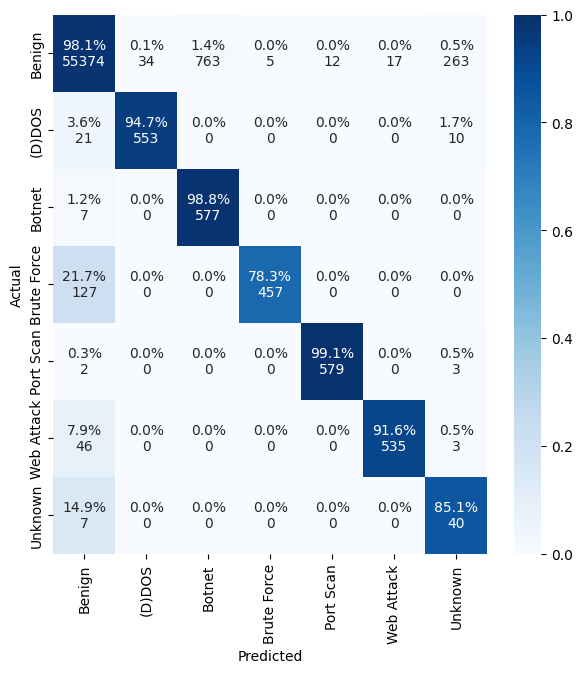

In [34]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes)

## Train second stage with anomaly score stage 1 as extra feature

In [35]:
proba_train = -ocsvm_model_100k.decision_function(train['stage2']['x_s'])
proba_val = -ocsvm_model_100k.decision_function(val['stage2']['x_s'])
proba_test = -ocsvm_model_100k.decision_function(test['stage2_s'])

In [36]:
proba_val.shape

(3000,)

In [37]:
val['stage2']['x_s'].shape

(3000, 67)

In [38]:
test['stage2_s'].shape

(59435, 67)

In [39]:
train_with_proba = np.column_stack((train['stage2']['x_s'], proba_train))
val_with_proba = np.column_stack((val['stage2']['x_s'], proba_val))
test_with_proba = np.column_stack((test['stage2_s'], proba_test))

In [40]:
train_with_proba.shape

(5320, 68)

In [41]:
val_with_proba.shape

(3000, 68)

In [42]:
test_with_proba.shape

(59435, 68)

Use new feature set to train and validate the model

In [43]:
params = {
    "n_estimators": 97,
    "max_samples": 0.9034128710297624,
    "max_features": 0.1751204590963604,
    "min_samples_leaf": 1
}
rf_model_extra_feature = create_rf({})
rf_model_extra_feature.fit(train_with_proba, train["stage2"]["y"])
with open(output_dir / "sota_stage2.p", "wb") as f:
    pickle.dump(rf_model_extra_feature, f)
print("Saved sota_stage2.p")

Saved sota_stage2.p


In [44]:
y_proba_val_2_extra_feature = rf_model_extra_feature.predict_proba(val_with_proba)

In [45]:
fmacro, fweight, threshold_fscore, f_best = optimal_fscore_multi(val['stage2']['y'], y_proba_val_2_extra_feature, rf_model_extra_feature.classes_)
print(f_best["f1_weighted_threshold"])
y_pred_val_2_extra_feature = np.where(np.max(y_proba_val_2_extra_feature, axis=1) > f_best["f1_weighted_threshold"], rf_model_extra_feature.classes_[np.argmax(y_proba_val_2_extra_feature, axis=1)], 'Unknown')

0.93


In [46]:
y_proba_test_2_extra_feature = rf_model_extra_feature.predict_proba(test_with_proba)
y_pred_test_2_extra_feature = np.where(np.max(y_proba_test_2_extra_feature, axis=1) > f_best["f1_weighted_threshold"], rf_model_extra_feature.classes_[np.argmax(y_proba_test_2_extra_feature, axis=1)], 'Unknown')
print({
    "f1_macro": f1_score(test["y_unknown_all"], y_pred_test_2_extra_feature, average='macro'),
    "f1_weighted": f1_score(test["y_unknown_all"], y_pred_test_2_extra_feature, average='weighted'),
    'accuracy': accuracy_score(test["y_unknown_all"], y_pred_test_2_extra_feature),
    'balanced_accuracy': balanced_accuracy_score(test["y_unknown_all"], y_pred_test_2_extra_feature)
})

{'f1_macro': 0.8663667182233894, 'f1_weighted': 0.9809039867593953, 'accuracy': 0.977572137629343, 'balanced_accuracy': 0.9779927905348603}


With default parameters of original training set

In [47]:
{'f1_macro': 0.8663667182233894, 'f1_weighted': 0.9809039867593953, 'accuracy': 0.977572137629343, 'balanced_accuracy': 0.9779927905348603}

{'f1_macro': 0.8663667182233894,
 'f1_weighted': 0.9809039867593953,
 'accuracy': 0.977572137629343,
 'balanced_accuracy': 0.9779927905348603}

## Full model performance

In [48]:
# y_proba_2 = predictions['stage2'][9] # Using saved results from initial experiment
y_proba_2 = y_proba_test_2_extra_feature # See training rf above

In [49]:
threshold_b = -0.0045741559351979745 # F9 100k
y_pred = np.where(y_proba_1 < threshold_b, "Benign", "Fraud").astype(object)
print(np.unique(y_pred, return_counts=True))

(array(['Benign', 'Fraud'], dtype=object), array([24490, 34945]))


In [50]:
threshold_m = 0.93 # See table above
y_pred_2 = np.where(np.max(y_proba_2[y_pred == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred == "Fraud"], axis=1)], 'Unknown')
np.unique(y_pred_2, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
        'Web Attack'], dtype=object),
 array([  703,  1400,   550,   594, 30856,   842]))

In [51]:
y_pred[y_pred == "Fraud"] = y_pred_2
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  703, 24490,  1400,   550,   594, 30856,   842]))

In [52]:
threshold_u = 0.0029087824072017237 # 0.99 100k
y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
np.unique(y_pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([30292,   564]))

In [53]:
y_pred[y_pred == "Unknown"] = y_pred_3
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  703, 54782,  1400,   550,   594,   564,   842]))

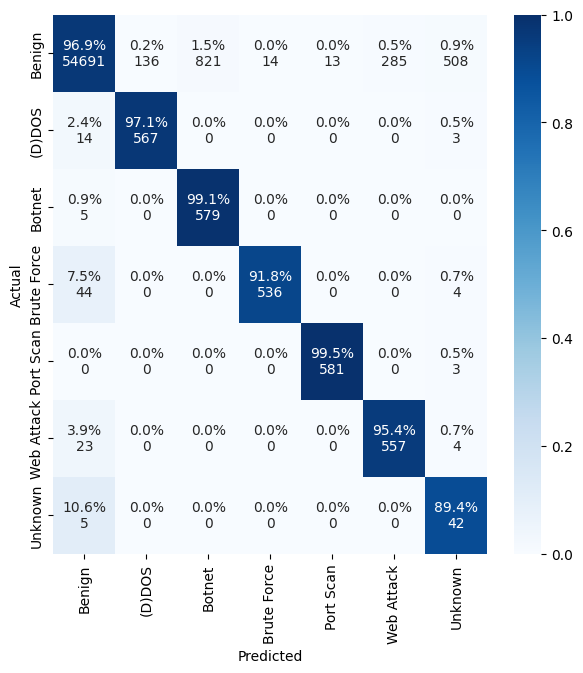

In [54]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes)

# With default params

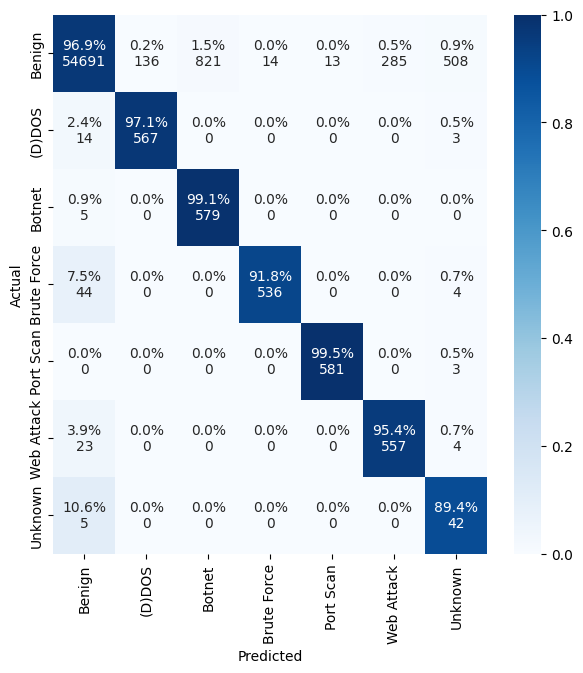

In [55]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes)

In [56]:
def generateConfusionGraphs(y_proba_2_new, threshold_m, include_metrics=False):
    fig, axs = plt.subplots(2,3, figsize=(18,12))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.3)
    y_proba_1 = score_test_100k
    metrics = []
    classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
    
    y_pred_1_n = np.where(y_proba_1 < threshold_b, 1, -1)
    confusion_1_binary = plot_confusion_matrix(test['y_n'], y_pred_1_n, values=[1, -1], labels=["Benign", "Fraud"], title="Stage 1", ax=axs[0, 0])
    y_pred = np.where(y_proba_1 < threshold_b, "Benign", "Fraud")
    
    y_proba_2 = y_proba_2_new
    y_pred_2 = np.where(np.max(y_proba_2[y_pred == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred == "Fraud"], axis=1)], 'Unknown')
    confusion_2_multi = plot_confusion_matrix(test['y_unknown'][y_pred == "Fraud"], y_pred_2, values=classes, labels=classes, title="Stage 2", ax=axs[0, 1])

    y_pred = y_pred.astype(object)
    y_pred[y_pred == "Fraud"] = y_pred_2
    if include_metrics:
        result_12 = {
            "threshold_b": threshold_b,
            "threshold_m": threshold_m,
            "threshold_u": "-",
            "bACC": balanced_accuracy_score(test['y_unknown'], y_pred),
            "ACC": accuracy_score(test['y_unknown'], y_pred),
            "f1_micro": f1_score(test['y_unknown'], y_pred, average='micro'),
            "f1_macro": f1_score(test['y_unknown'], y_pred, average='macro'),
            "f1_weighted": f1_score(test['y_unknown'], y_pred, average='weighted'),
            "zero_day_recall_extension": "-",
            "zero_day_recall_total": "-"
        }
        metrics.append(result_12)
    confusion_12_multi = plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes, title="Stage 1&2 Combined", ax=axs[0, 2])
    mask = ((y_pred == "Unknown") & (test['y_unknown_all'] == "Unknown"))
    
    y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
    y_pred_3_n = np.where(y_proba_1[mask] < threshold_u, 1, -1)
    confusion_3_multi = plot_confusion_matrix(test['y_unknown'][y_pred == "Unknown"], y_pred_3, values=classes, labels=classes, title="Extension Multi-Class", ax=axs[1, 0])
    confusion_3_binary = plot_confusion_matrix(test['y_n'][mask], y_pred_3_n, values=[1, -1], labels=["Benign", "Zero-Day"], title="Extension Binary", ax=axs[1, 1])

    y_pred[y_pred == "Unknown"] = y_pred_3
    if include_metrics:
        result_123 = {
            "threshold_b": threshold_b,
            "threshold_m": threshold_m,
            "threshold_u": threshold_u,
            "bACC": balanced_accuracy_score(test['y_unknown'], y_pred),
            "ACC": accuracy_score(test['y_unknown'], y_pred),
            "f1_micro": f1_score(test['y_unknown'], y_pred, average='micro'),
            "f1_macro": f1_score(test['y_unknown'], y_pred, average='macro'),
            "f1_weighted": f1_score(test['y_unknown'], y_pred, average='weighted'),
            "zero_day_recall_extension": recall_score(test['y_n'][mask], y_pred_3_n, pos_label=-1),
            "zero_day_recall_total": (y_pred_3_n == -1).sum() / 47
        }
        metrics.append(result_123)
    confusion_123_multi = plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes, title="Stages 1,2 & Extension Combined", ax=axs[1, 2])
    return pd.DataFrame(metrics)

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.004574,0.93,-,0.894534,0.459595,0.459595,0.683539,0.614893,-,-
1,-0.004574,0.93,0.002909,0.955845,0.968335,0.968335,0.756918,0.975286,0.893617,11.702128


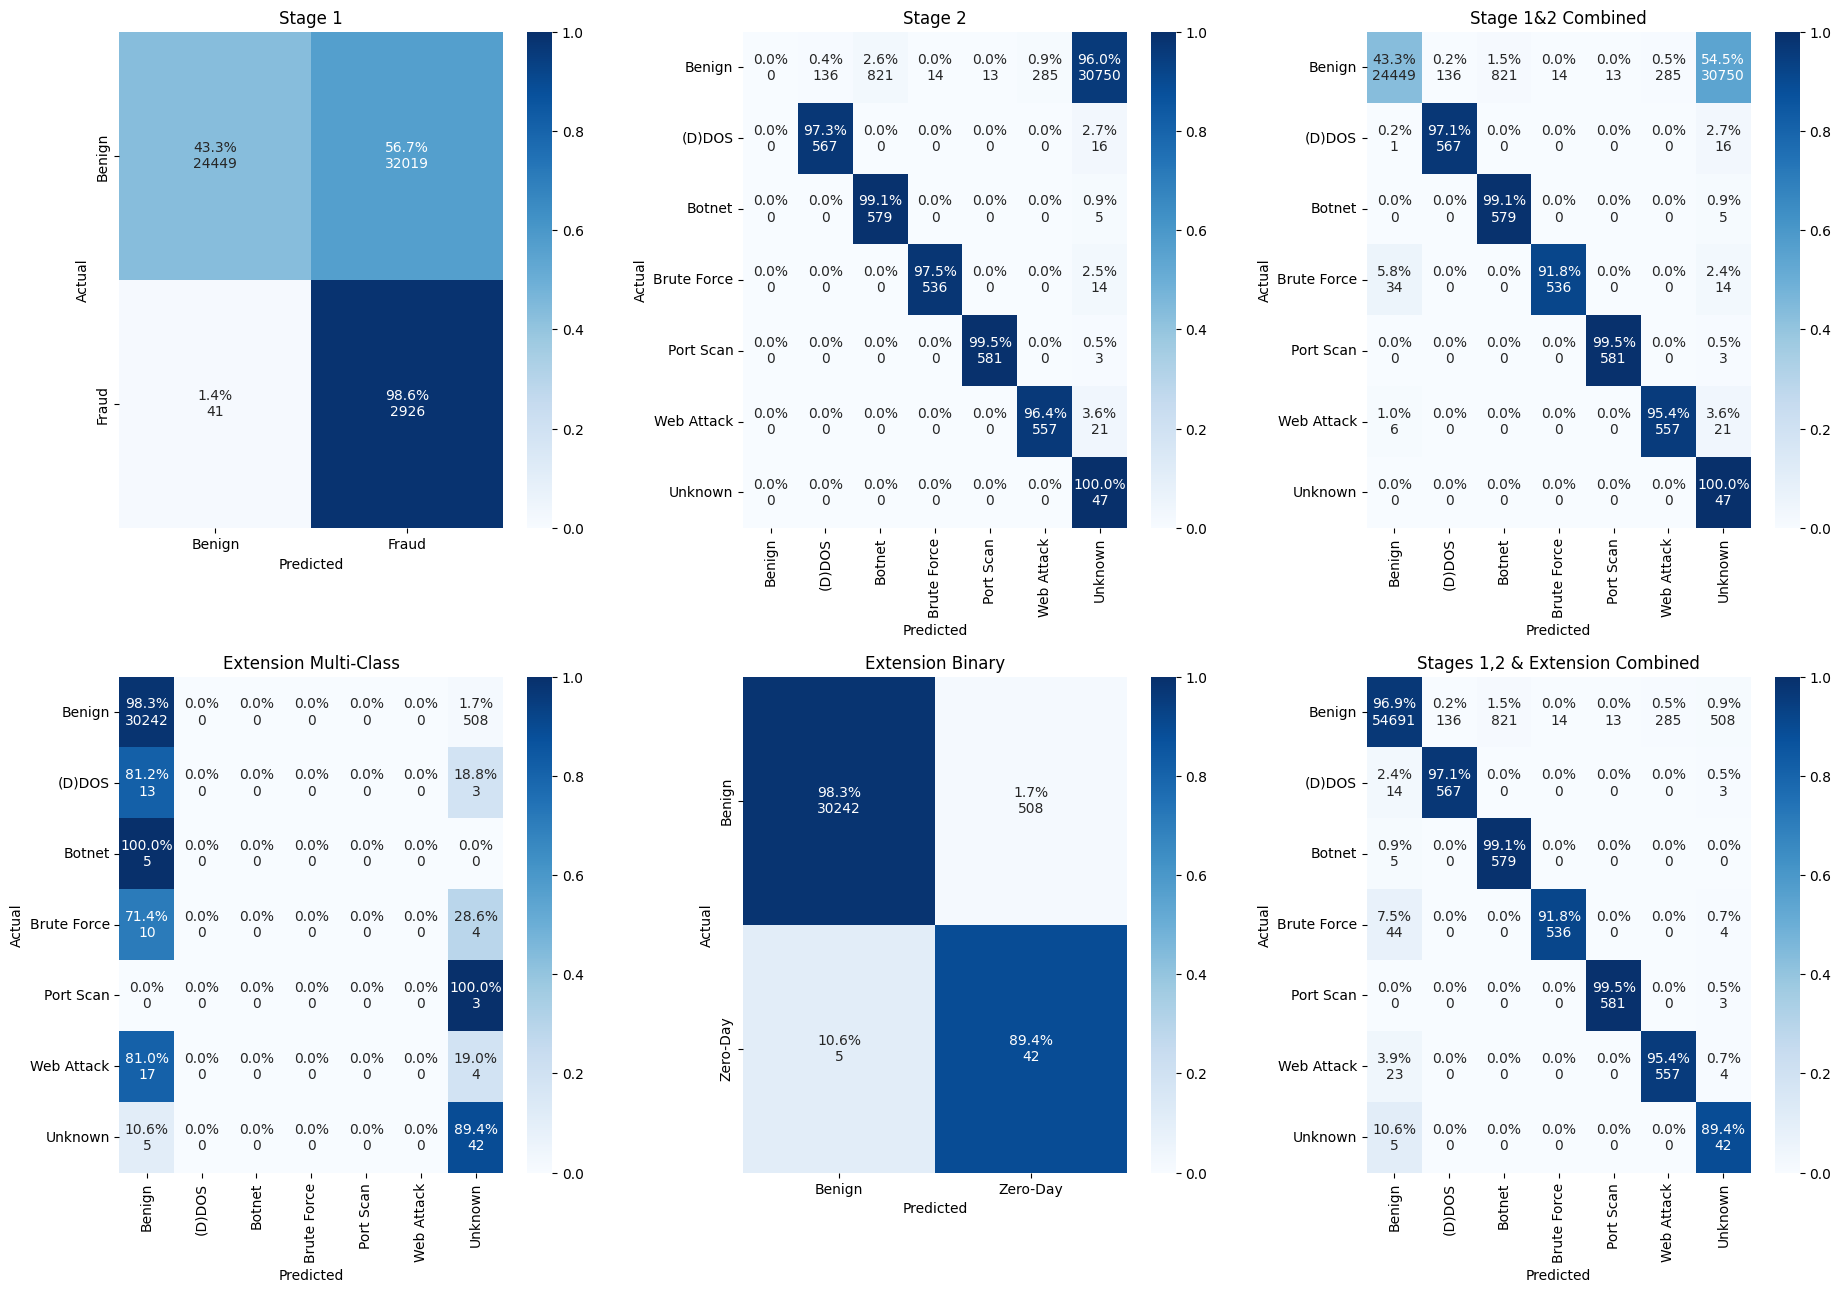

In [57]:
generateConfusionGraphs(y_proba_test_2_extra_feature, 0.93, True)

# Default model params

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.004574,0.94,-,0.893556,0.459527,0.459527,0.689030,0.615271,-,-
1,-0.004574,0.94,0.002909,0.955069,0.969614,0.969614,0.762447,0.976332,0.893617,11.723404


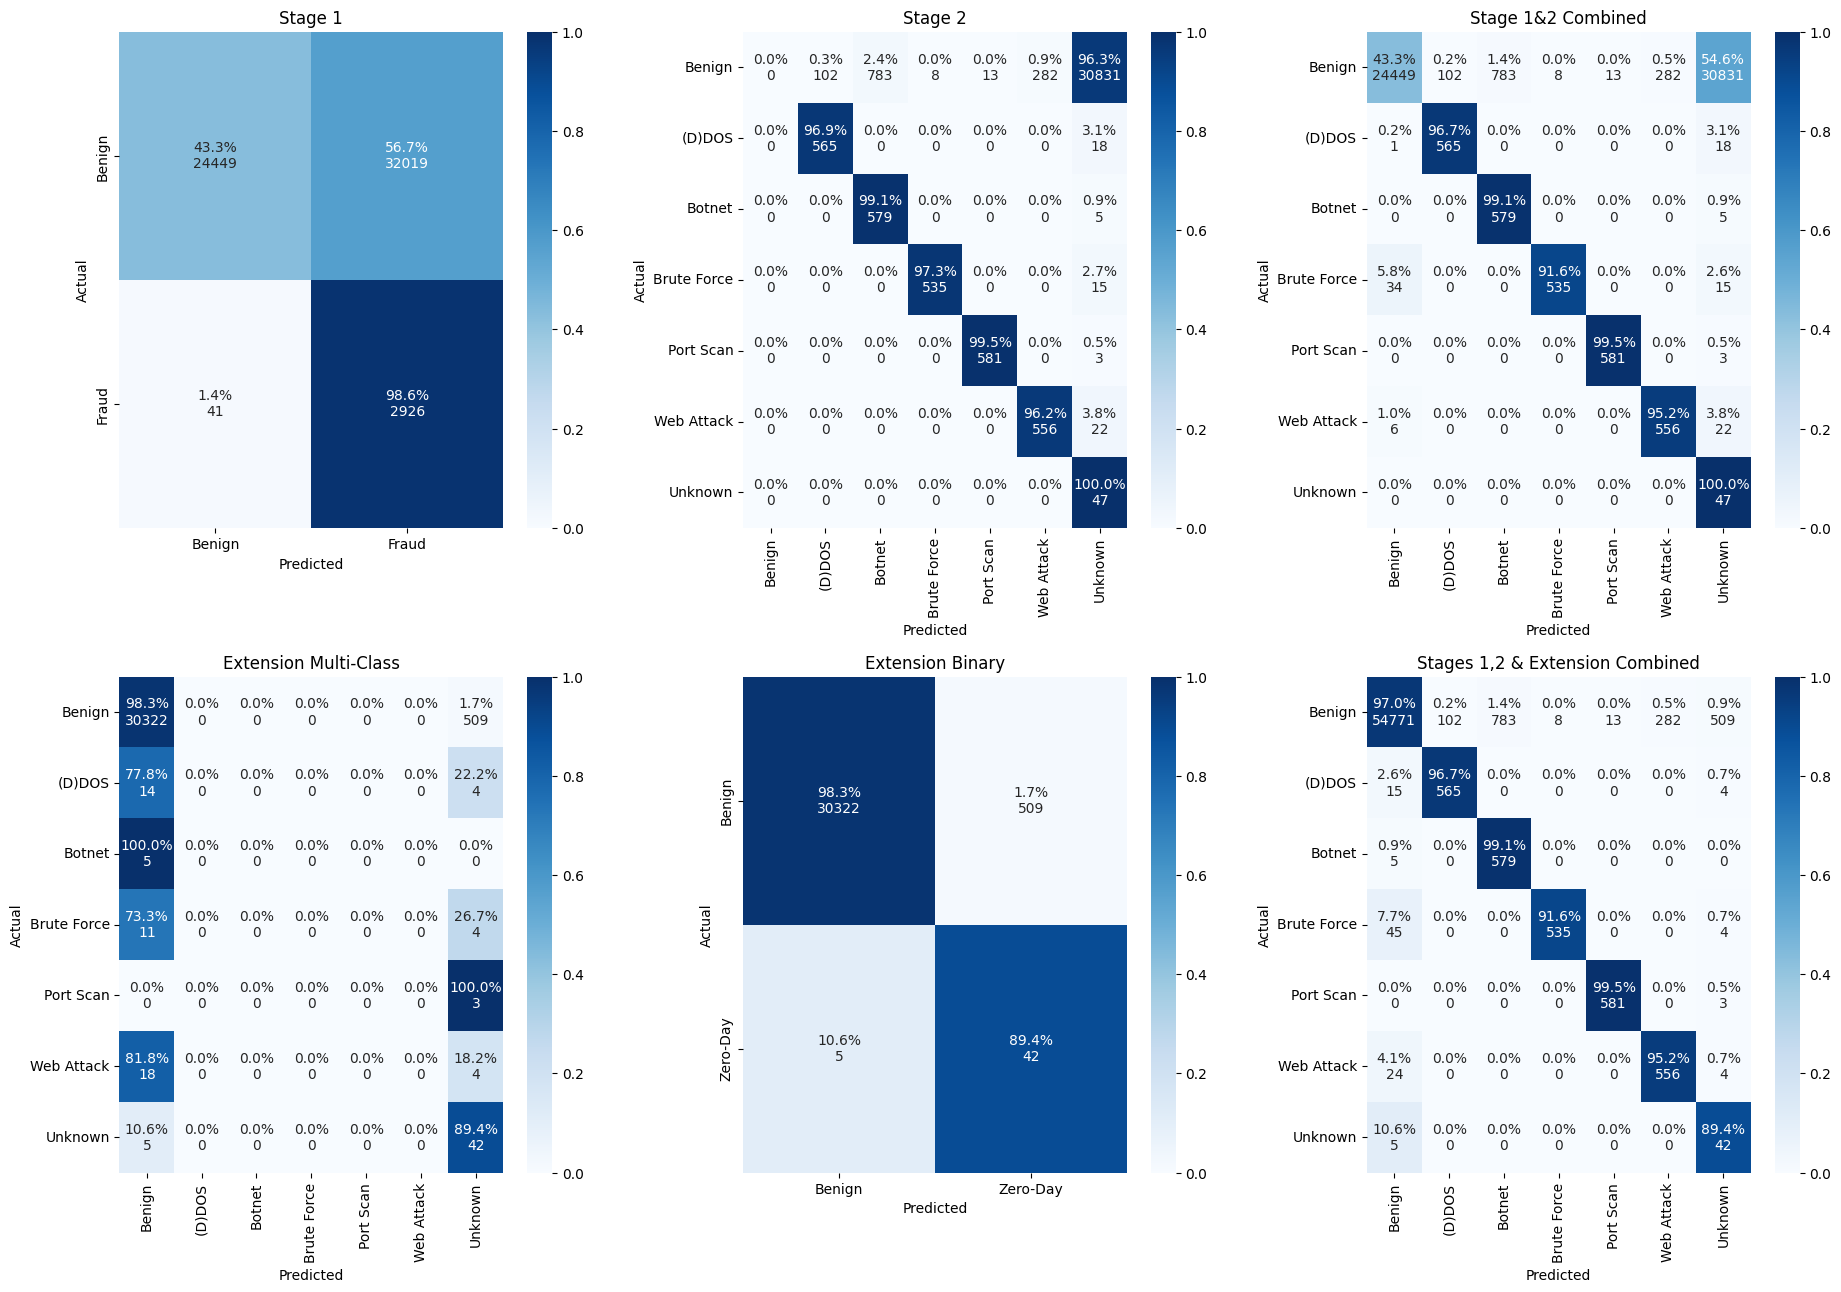

In [58]:
generateConfusionGraphs(y_proba_test_2_extra_feature, 0.94, True)

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.004574,0.96,-,0.890375,0.459308,0.459308,0.695120,0.615690,-,-
1,-0.004574,0.96,0.002909,0.952109,0.970859,0.970859,0.768572,0.977404,0.893617,11.744681


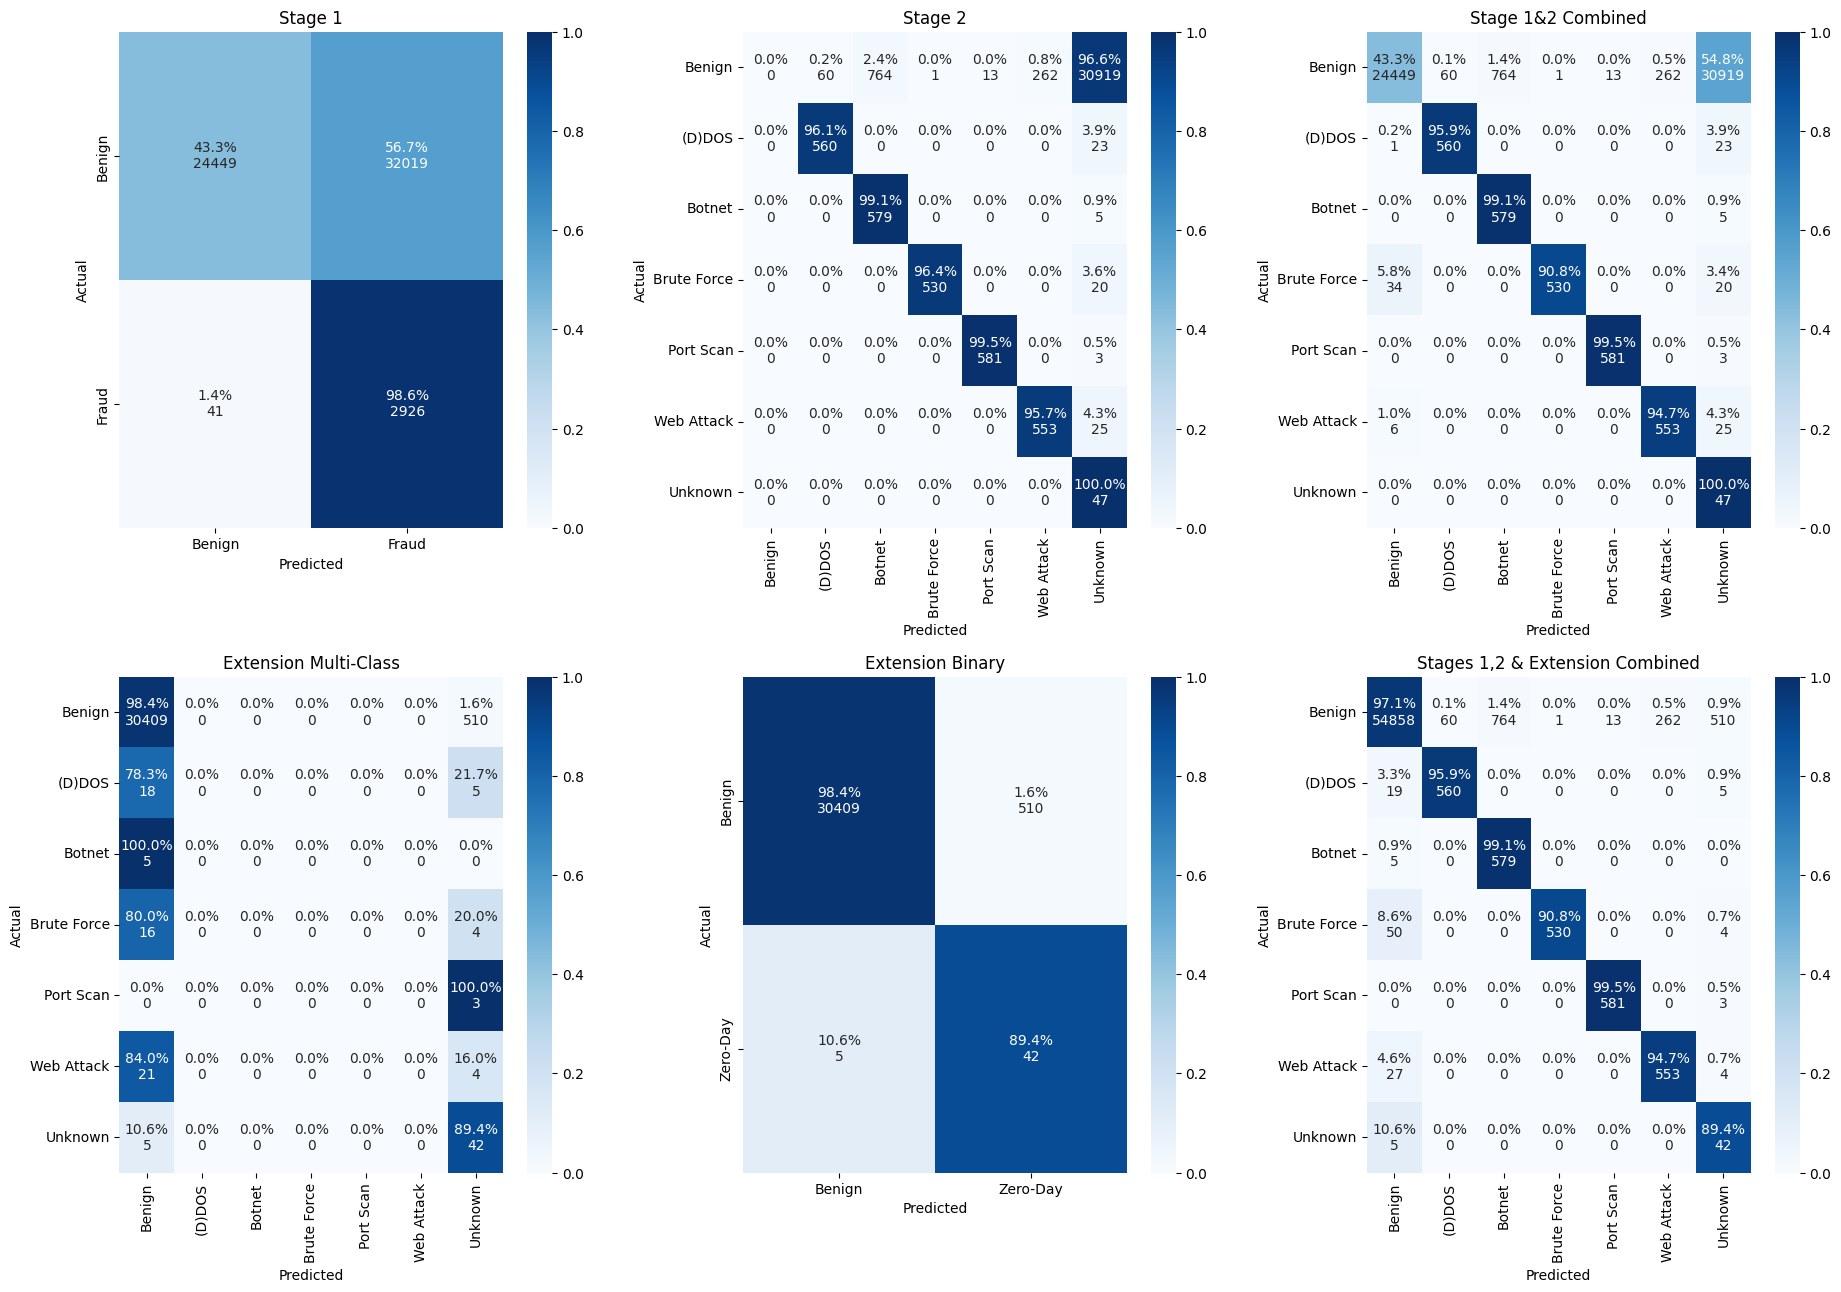

In [59]:
generateConfusionGraphs(y_proba_test_2_extra_feature, 0.96, True)

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.004574,0.94,-,0.891599,0.459393,0.459393,0.643820,0.612161,-,-
1,-0.004574,0.94,0.002909,0.951647,0.959738,0.959738,0.716461,0.968116,0.893617,11.702128


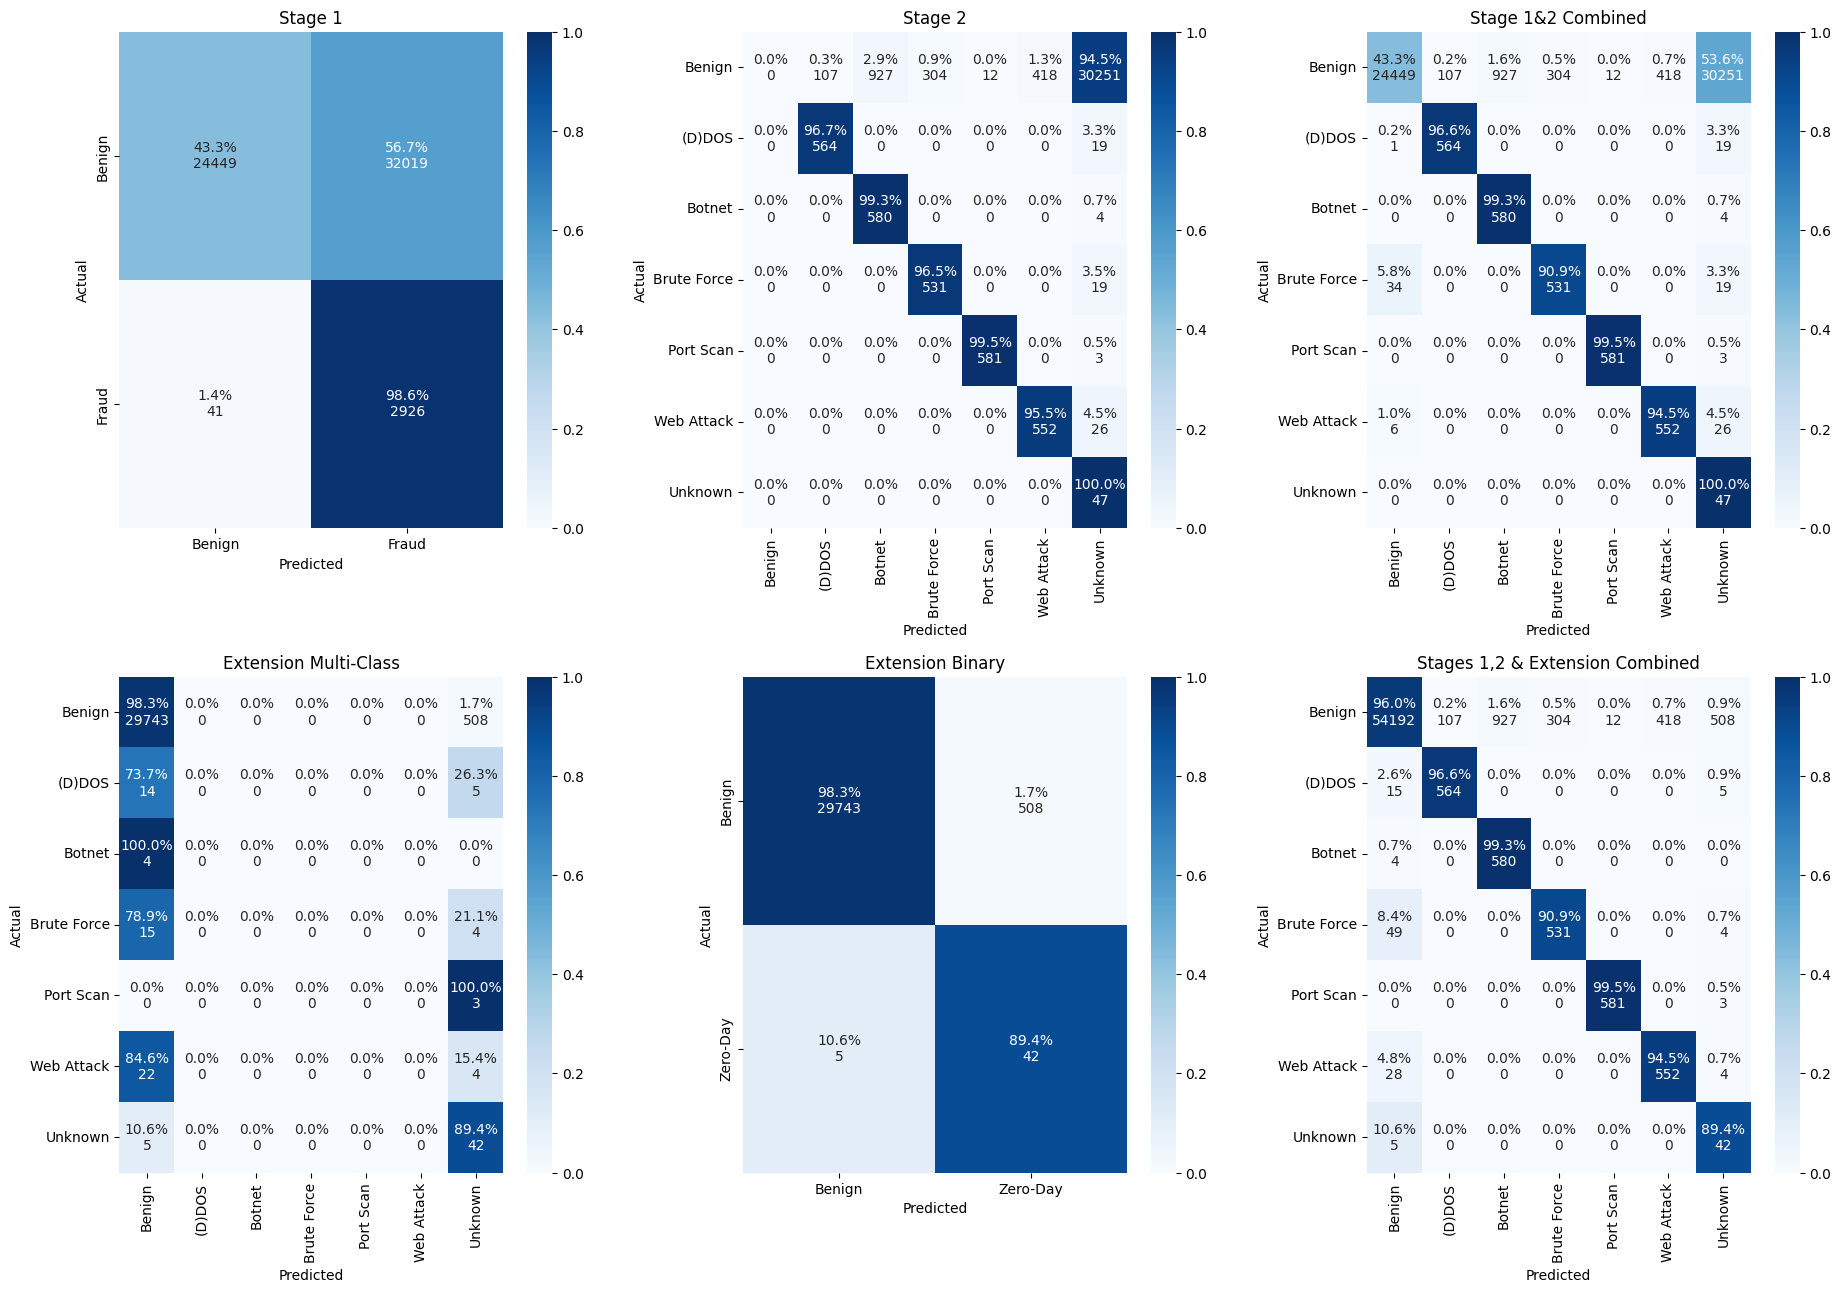

In [60]:
generateConfusionGraphs(y_proba_test_2, 0.94, True)

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.004574,0.96,-,0.888908,0.459208,0.459208,0.691745,0.615458,-,-
1,-0.004574,0.96,0.002909,0.950578,0.970337,0.970337,0.765068,0.976938,0.893617,11.723404


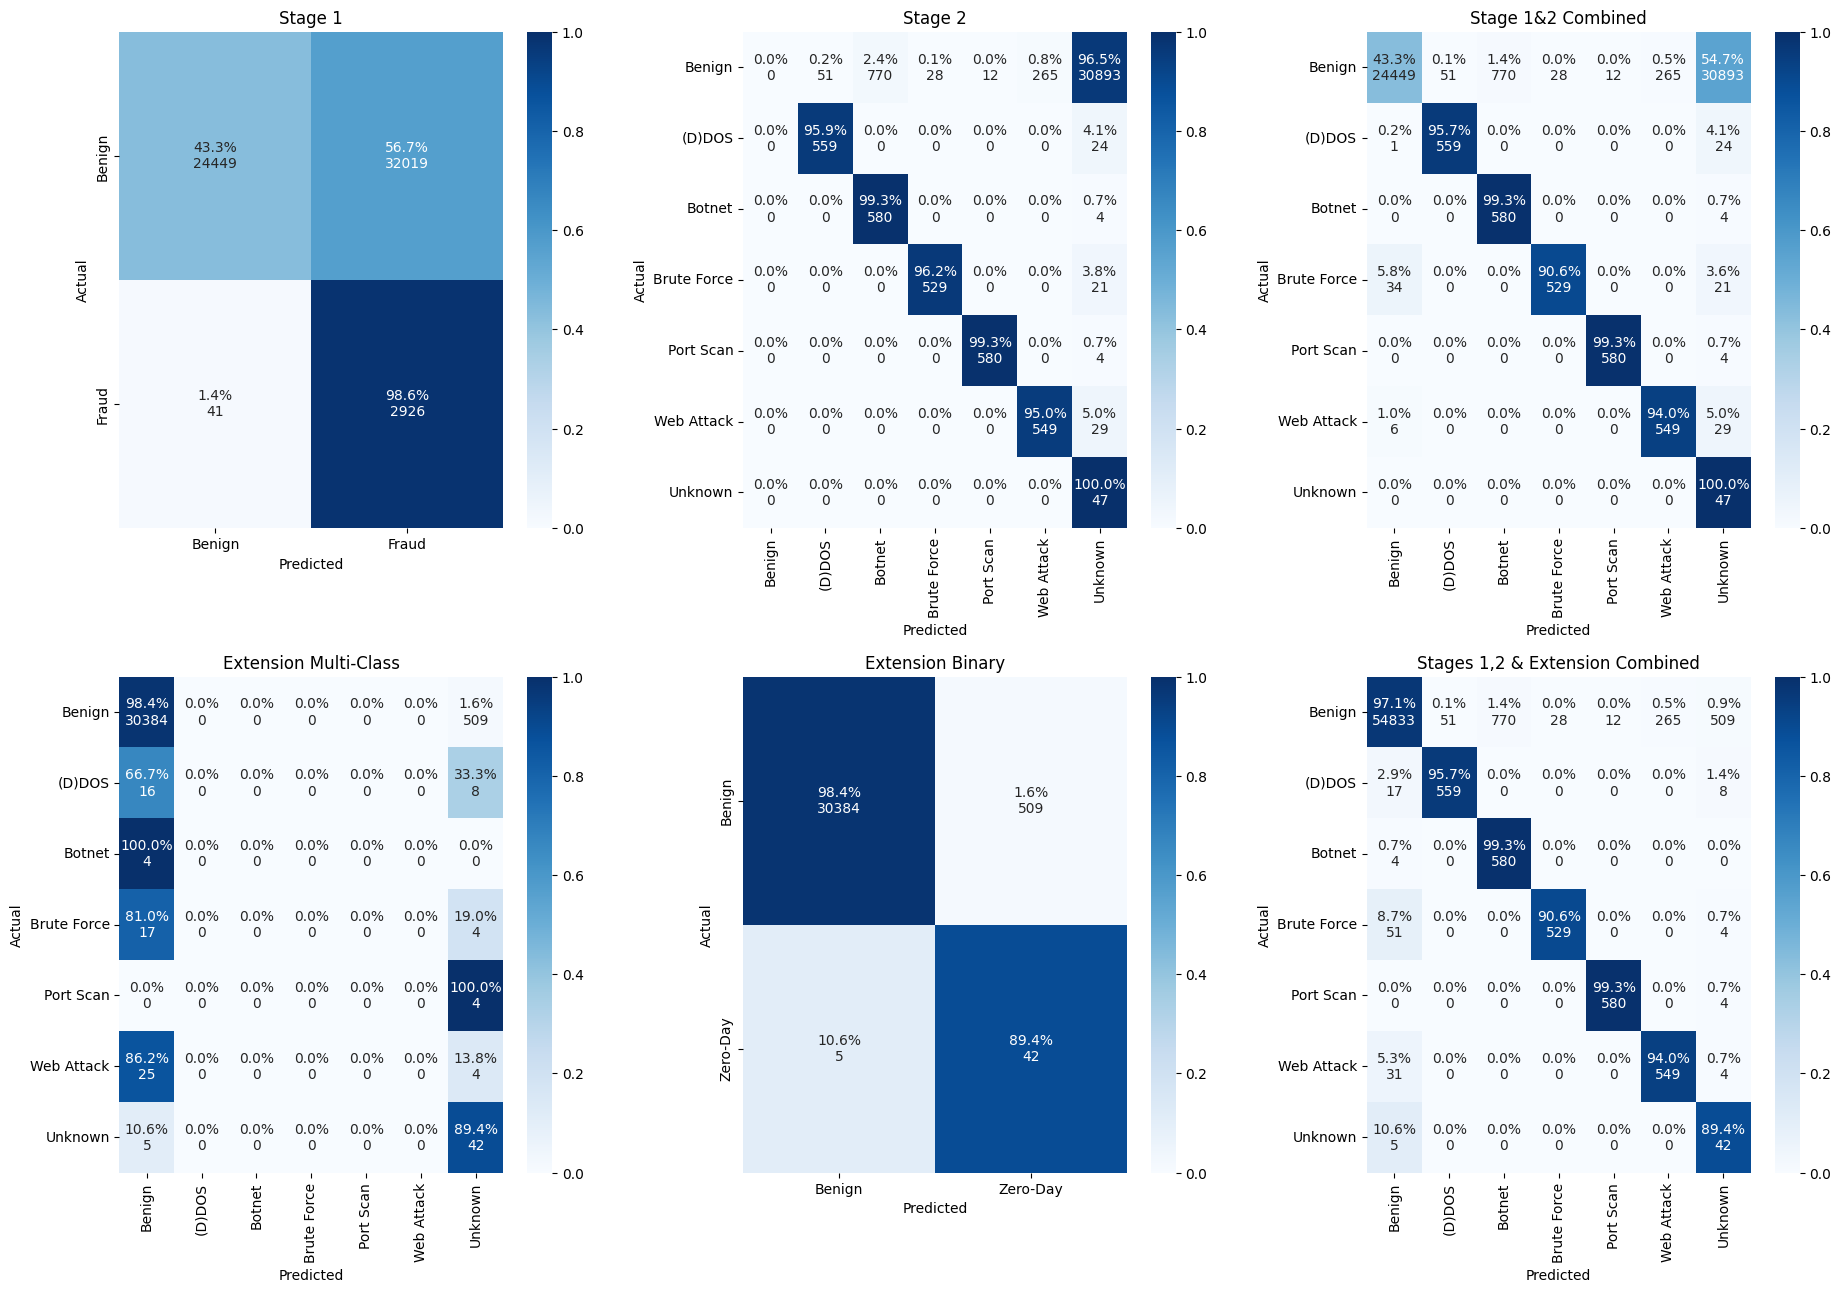

In [61]:
generateConfusionGraphs(y_proba_test_2, 0.96, True)

,threshold_b,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,-0.004574,0.98,-,0.883037,0.458804,0.458804,0.717800,0.617250,-,-
1,-0.004574,0.98,0.002909,0.945451,0.974880,0.974880,0.791299,0.981109,0.893617,11.744681


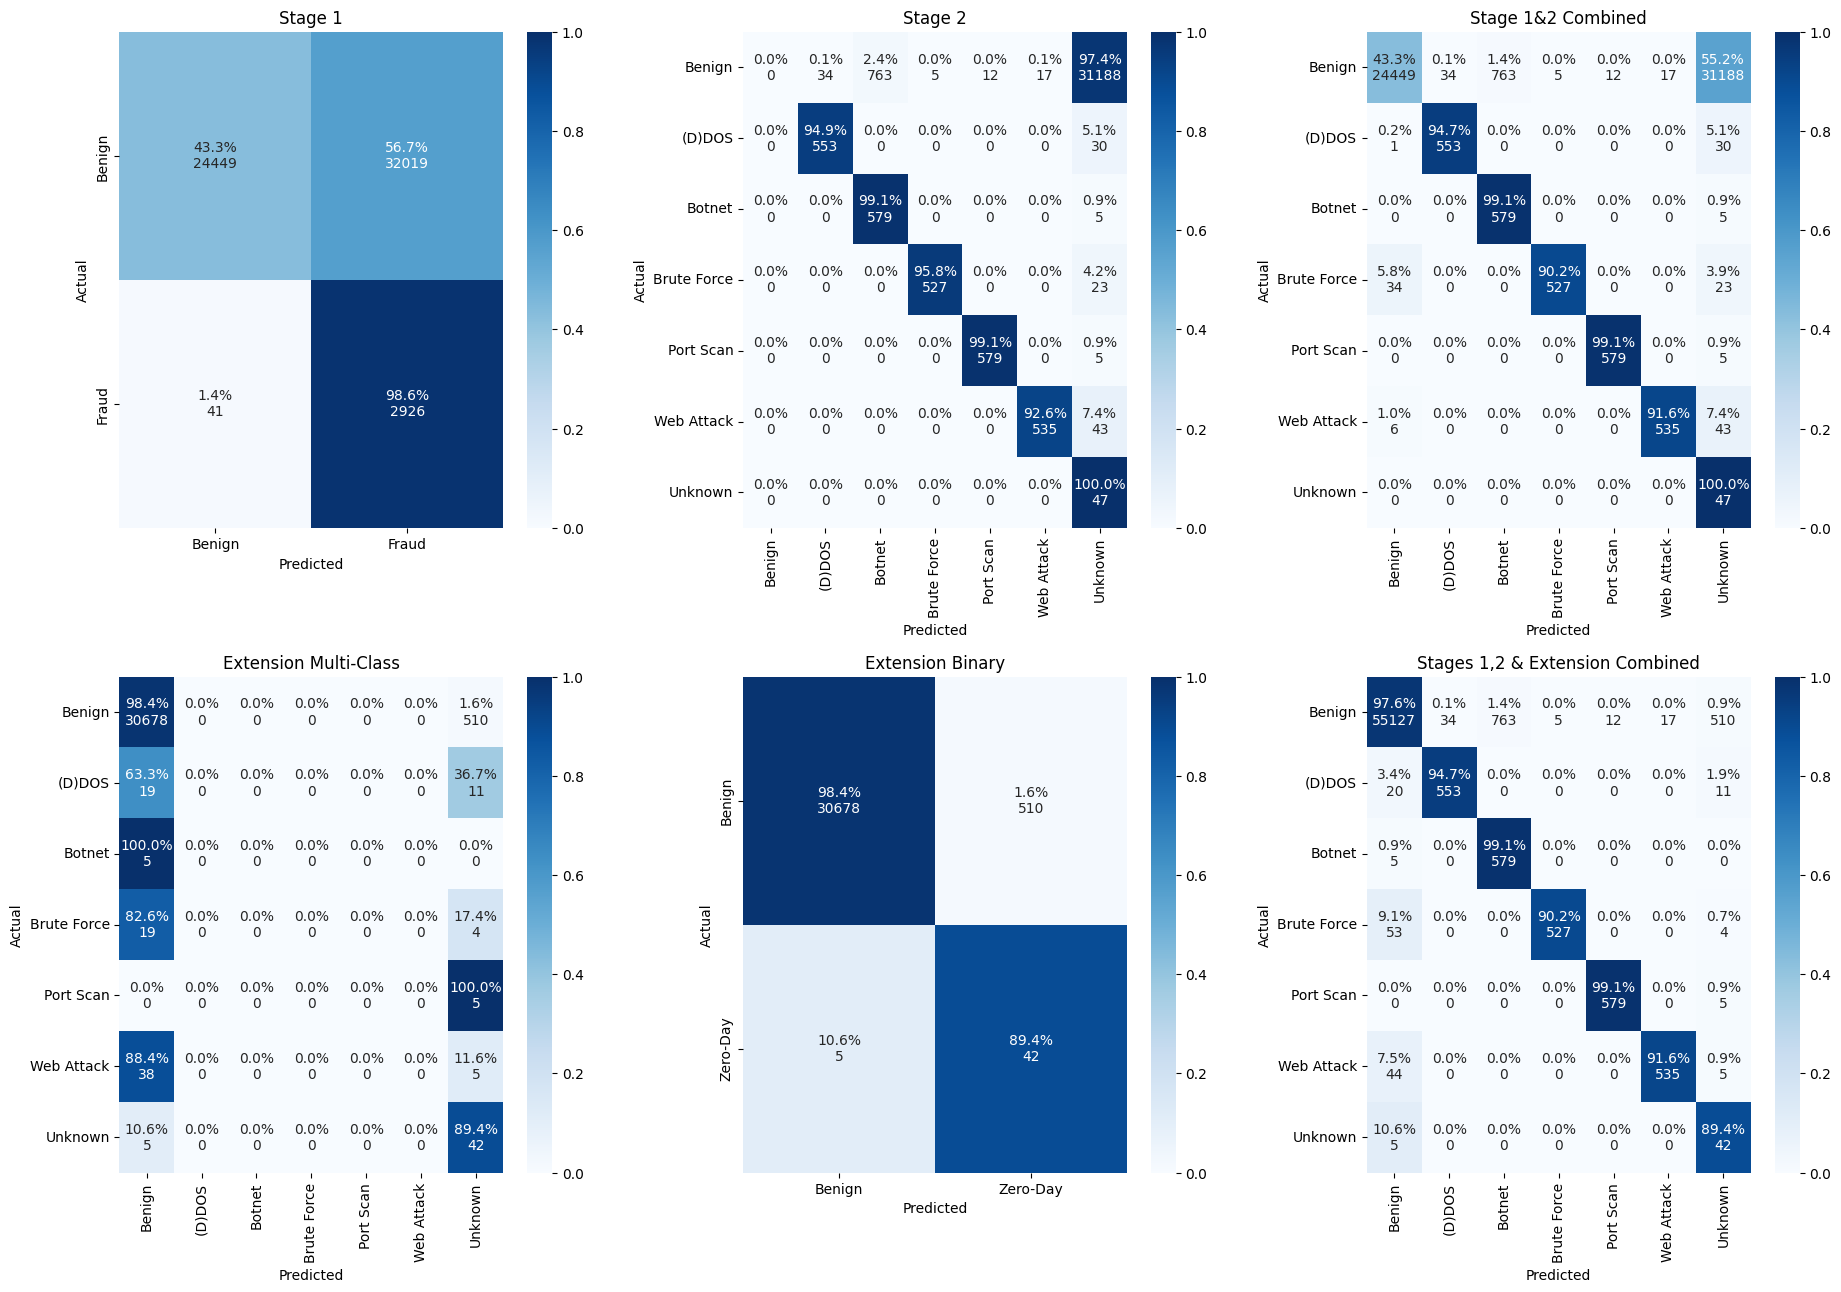

In [62]:
generateConfusionGraphs(y_proba_test_2, 0.98, True)